In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-09-17 07:31:47--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.3’

AB_NYC_2019.csv.3   100%[===================>]   6.75M  --.-KB/s    in 0.07s   

2021-09-17 07:31:48 (102 MB/s) - ‘AB_NYC_2019.csv.3’ saved [7077973/7077973]



In [3]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
price = data.price
price

0        149
1        225
2        150
3         89
4         80
        ... 
48890     70
48891     40
48892    115
48893     55
48894     90
Name: price, Length: 48895, dtype: int64

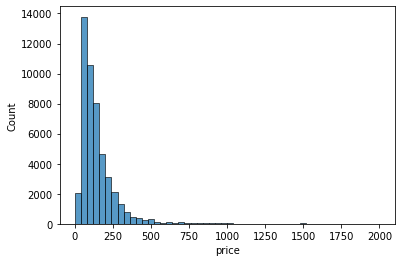

In [6]:
sns.histplot(data.price[data.price<2000], bins=50)

In [7]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [8]:
df = data.loc[:, ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
                    'calculated_host_listings_count', 'availability_365']]

In [9]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [10]:
np.median(df['minimum_nights'])

3.0

In [11]:
df.shape

(48895, 8)

In [12]:
idx = np.arange(df.shape[0])
np.random.seed(42)
np.random.shuffle(idx)
idx

array([  879, 44383, 15394, ..., 38158,   860, 15795])

In [13]:
price = df.price

In [14]:
df.drop('price', axis=1, inplace = True)

In [15]:
n = df.shape[0]
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [16]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [17]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [18]:
df.shape

(48895, 7)

In [19]:
log_price = np.log1p(price)

In [20]:
price_train = log_price.iloc[idx[:n_train]]
price_val = log_price.iloc[idx[n_train:n_train+n_val]]
price_test = log_price.iloc[idx[n_train+n_val:]]

In [21]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [22]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [23]:
X_train = df_train.fillna(0).values
y_train = price_train.values
train_linear_regression(X_train, y_train)

(-419.91265973795873,
 array([ 1.30676226e+00, -5.02167856e+00, -5.59803111e-04, -4.07634897e-04,
        -8.25470060e-03,  1.33371319e-03,  6.50203891e-04]))

In [24]:
w0, w = train_linear_regression(X_train, y_train)

In [25]:
df_val_filled0 = df_val.fillna(0).values
y_pred_val = w0 + df_val_filled0.dot(w)

In [26]:
rmse(y_pred_val, price_val).round(2)

0.64

In [27]:
X_train_filled_mean = df_train.fillna(df_train.mean()).values
y_train = price_train.values
train_linear_regression(X_train_filled_mean, y_train)
w0, w = train_linear_regression(X_train_filled_mean, y_train)
df_val_filled_mean = df_val.fillna(df_train.mean()).values
y_pred_val_filled_mean = w0 + df_val_filled_mean.dot(w)

In [28]:
rmse(y_pred_val_filled_mean, price_val).round(2)

0.64

In [29]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [30]:
scores = {}
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = df_val.fillna(0).values

    y_pred = w0 + X_val.dot(w)
    score = rmse(price_val, y_pred)
    scores[r] = score.round(2)

scores

{0: 0.64,
 1e-06: 0.64,
 0.0001: 0.64,
 0.001: 0.64,
 0.01: 0.66,
 0.1: 0.68,
 1: 0.68,
 5: 0.68,
 10: 0.68}

In [31]:
score = []
for seed_value in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(df.shape[0])
    np.random.seed(seed_value)
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]].reset_index(drop = True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop = True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop = True)
    price_train = log_price.iloc[idx[:n_train]]
    price_val = log_price.iloc[idx[n_train:n_train+n_val]]
    price_test = log_price.iloc[idx[n_train+n_val:]]
    X_train = df_train.fillna(0).values
    y_train = price_train.values
    w0, w = train_linear_regression(X_train, y_train)
    df_val_filled0 = df_val.fillna(0).values
    y_pred_val = w0 + df_val_filled0.dot(w)
    score.append(rmse(y_pred_val, price_val))

In [32]:
np.std(score).round(3)

0.008

In [33]:
idx = np.arange(df.shape[0])
np.random.seed(9)
np.random.shuffle(idx)
df_train = df.iloc[idx[:n_train+n_val]].reset_index(drop = True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop = True)

In [34]:
price_train = log_price.iloc[idx[:n_train+n_val]]
price_test = log_price.iloc[idx[n_train+n_val:]]

In [35]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [36]:
df_train = df_train.fillna(0).values
df_test = df_test.fillna(0).values
w0, w = train_linear_regression_reg(df_train, price_train, 0.001)
y_pred = w0 + df_test.dot(w)

In [37]:
rmse(price_test, y_pred).round(2)

0.65